# Introduction to Deep Learning
## Assignment 3
### Task 1: Recurrent Neural Networks
<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 

The goal of this task is to learn how to use encoder-decoder recurrent models. Specifically we will be dealing with a sequence to sequence problem and try to develop a neural network that can learn the principles behind simple arithmetic operations.



To work on this notebook you should create a copy of it.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell , Dropout
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
from keras.layers import CuDNNLSTM, Bidirectional, MaxPooling3D
import matplotlib.pyplot as plt
from tensorflow.keras.experimental import PeepholeLSTMCell

# Function definitions for creating the dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

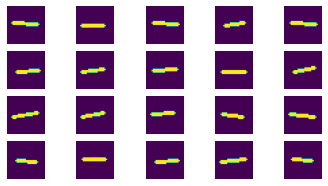

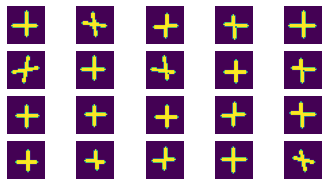

In [2]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2))
    y1 = np.random.randint(4, 8, n)
    y2 = np.random.randint(20, 24, n)
    
    blank = np.zeros([n, 28, 28])
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [3]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1):
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length)
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

11501568/11490434 [==============================] - 0s 0us/step
(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 69143

X_text: "172+171" = y_text: " 343"


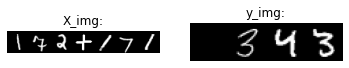

Sample ID: 19989

X_text: " 49+194" = y_text: " 243"


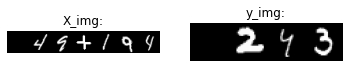

Sample ID: 33376

X_text: " 83- 88" = y_text: "  -5"


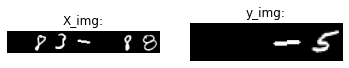

Sample ID: 43490

X_text: "108-145" = y_text: " -37"


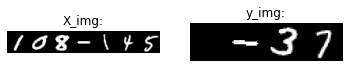

Sample ID: 57923

X_text: "144+161" = y_text: " 305"


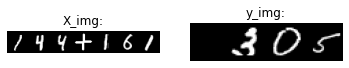

Sample ID: 17236

X_text: " 43- 18" = y_text: "  25"


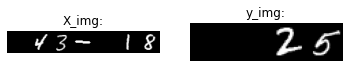

Sample ID: 48106

X_text: "120- 53" = y_text: "  67"


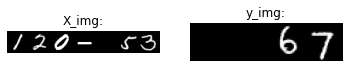

Sample ID: 54201

X_text: "135+100" = y_text: " 235"


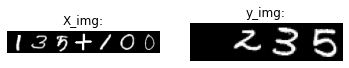

Sample ID: 44672

X_text: "111-136" = y_text: " -25"


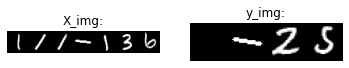

Sample ID: 49904

X_text: "124-152" = y_text: " -28"


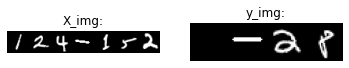

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) # 
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=4):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)
# 13 because  numbers of 0 to 9 + blank space + "-" and "+"

(80000, 7, 13) (80000, 4, 13)


---
---

# 1. Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network
LSTM (Long Short Term Memory) layers can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [11]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))


# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(LSTM(128, return_sequences=True))


# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 4, 256)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 13)            1677      
 tributed)                                                       
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


In [9]:
inx = np.random.permutation(len(X_img))
X_text_onehot = X_text_onehot[inx,:,:]
y_text_onehot = y_text_onehot[inx,:,:]

X_train_text_onehot = X_text_onehot[:72000,:,:]
X_test_text_onehot = X_text_onehot[72000:,:,:]

y_trian_text_onehot = y_text_onehot[:72000,:,:]
y_test_text_onehot = y_text_onehot[72000:,:,:]

In [12]:
history  = text2text.fit(X_train_text_onehot, y_trian_text_onehot, epochs=10, batch_size = 512, validation_data = (X_test_text_onehot,y_test_text_onehot))
#After 10 epochs stucks at 0.70 on train and 0.55 on test accuracy

Epoch 1/10
141/141 [==============================] - 7s 23ms/step - loss: 1.6831 - accuracy: 0.3843 - val_loss: 1.4375 - val_accuracy: 0.4343
Epoch 2/10
141/141 [==============================] - 2s 15ms/step - loss: 1.3717 - accuracy: 0.4588 - val_loss: 1.3037 - val_accuracy: 0.4813
Epoch 3/10
141/141 [==============================] - 2s 15ms/step - loss: 1.2572 - accuracy: 0.5039 - val_loss: 1.2126 - val_accuracy: 0.5355
Epoch 4/10
141/141 [==============================] - 2s 15ms/step - loss: 1.1721 - accuracy: 0.5464 - val_loss: 1.1433 - val_accuracy: 0.5579
Epoch 5/10
141/141 [==============================] - 2s 15ms/step - loss: 1.0946 - accuracy: 0.5853 - val_loss: 1.0502 - val_accuracy: 0.6097
Epoch 6/10
141/141 [==============================] - 2s 15ms/step - loss: 1.0228 - accuracy: 0.6156 - val_loss: 0.9819 - val_accuracy: 0.6439
Epoch 7/10
141/141 [==============================] - 2s 15ms/step - loss: 0.9571 - accuracy: 0.6472 - val_loss: 0.9726 - val_accuracy: 0.6196

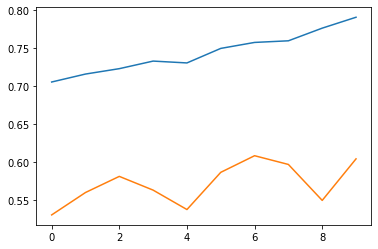

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

Trying to improve the model

In [ ]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(GRU(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))
# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(GRU(128, return_sequences=True))
text2text.add(GRU(64, return_sequences=True))
# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)
# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
text2text.fit(X_train_text_onehot, y_trian_text_onehot, epochs=10, batch_size = 512, validation_data = (X_test_text_onehot,y_test_text_onehot))
#After 20 epochs with 

Epoch 1/10
141/141 [==============================] - 3s 21ms/step - loss: 0.1783 - accuracy: 0.9549 - val_loss: 0.3927 - val_accuracy: 0.8641
Epoch 2/10
141/141 [==============================] - 3s 20ms/step - loss: 0.1427 - accuracy: 0.9676 - val_loss: 0.3784 - val_accuracy: 0.8653
Epoch 3/10
141/141 [==============================] - 3s 20ms/step - loss: 0.1146 - accuracy: 0.9747 - val_loss: 0.3176 - val_accuracy: 0.9083
Epoch 4/10
141/141 [==============================] - 3s 19ms/step - loss: 0.1137 - accuracy: 0.9704 - val_loss: 0.2656 - val_accuracy: 0.9298
Epoch 5/10
141/141 [==============================] - 3s 19ms/step - loss: 0.0914 - accuracy: 0.9779 - val_loss: 0.3599 - val_accuracy: 0.8851
Epoch 6/10
141/141 [==============================] - 3s 19ms/step - loss: 0.0830 - accuracy: 0.9792 - val_loss: 0.3617 - val_accuracy: 0.8791
Epoch 7/10
141/141 [==============================] - 3s 18ms/step - loss: 0.1039 - accuracy: 0.9684 - val_loss: 0.2661 - val_accuracy: 0.9277

### Your tasks:


In [ ]:
# Train and experiment with the text-to-text RNN Model by using X_text and y_text as your inputs/outputs
# 1. Try different ratios of train/test splits
# 2. Try to find more optimal architectures

inx = np.random.permutation(len(X_img))
X_text_onehot = X_text_onehot[inx,:,:]
y_text_onehot = y_text_onehot[inx,:,:]


percentages = [76000,72000,68000,64000] #5,10,15,20 percent respectively
accuracy_list = []
val_accuracy_list = []
for percentage in percentages:
  X_train_text_onehot = X_text_onehot[:percentage,:,:]
  X_test_text_onehot = X_text_onehot[percentage:,:,:]
  y_trian_text_onehot = y_text_onehot[:percentage,:,:]
  y_test_text_onehot = y_text_onehot[percentage:,:,:]


  text2text = tf.keras.Sequential()

  text2text.add(GRU(256, input_shape=(max_query_length, len(unique_characters))))


  text2text.add(RepeatVector(max_answer_length))

  text2text.add(GRU(128, return_sequences=True))
  text2text.add(GRU(64, return_sequences=True))

  text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
  opt = tf.keras.optimizers.Adam(learning_rate=1e-3,decay=1e-5)

  text2text.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  history  = text2text.fit(X_train_text_onehot, y_trian_text_onehot, epochs=50, batch_size = 512, validation_data = (X_test_text_onehot,y_test_text_onehot), verbose=0)

  accuracy_list.append([history.history["accuracy"]])
  val_accuracy_list.append([history.history["val_accuracy"]])






<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

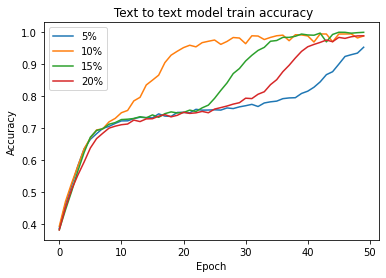

In [ ]:
from google.colab import files

plt.plot(accuracy_list[0][0])
plt.plot(accuracy_list[1][0])
plt.plot(accuracy_list[2][0])
plt.plot(accuracy_list[3][0])
plt.legend(["5%","10%","15%","20%"])
plt.title(' Text to text model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Model_train_accuracy.png')
files.download('Model_train_accuracy.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

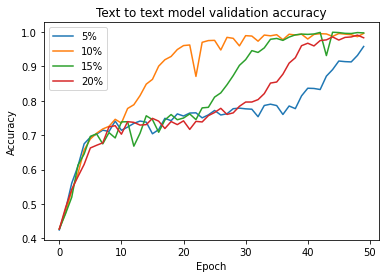

In [ ]:
plt.plot(val_accuracy_list[0][0])
plt.plot(val_accuracy_list[1][0])
plt.plot(val_accuracy_list[2][0])
plt.plot(val_accuracy_list[3][0])
plt.legend(["5%","10%","15%","20%"])
plt.title('Text to text model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Model_val_accuracy.png')
files.download('Model_val_accuracy.png') 

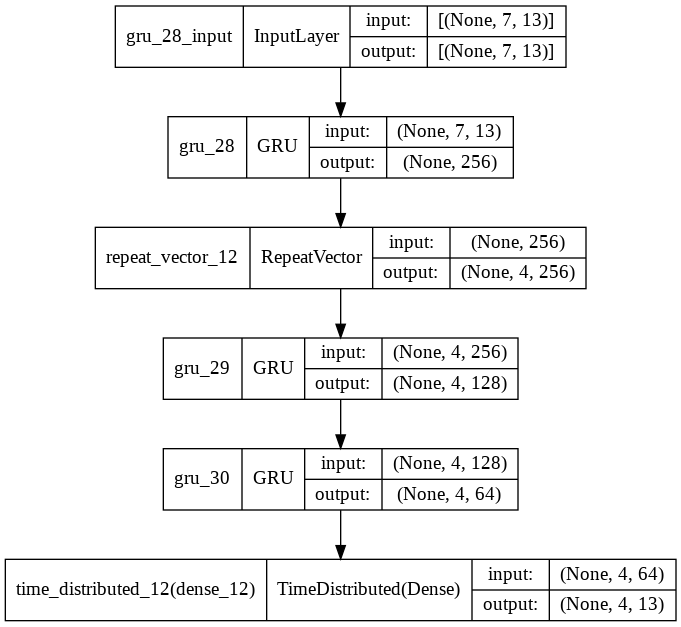

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(text2text, show_shapes=True, show_layer_names=True)


---
---

# 2. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

Preprocess the data. Do the split (according to our experiment in first task).
Also rescale the pixels.

In [ ]:
X_img = X_img[inx,:,:,:]
y_img = y_img[inx,:,:,:]
y_text_onehot = y_text_onehot[inx,:,:]

In [ ]:
# Our model
img2text = tf.keras.Sequential()
img2text.add(Reshape((max_query_length,28*28), input_shape = (max_query_length,28,28,1)))
img2text.add(LSTM(128,return_sequences = True))
img2text.add(LSTM(70))


img2text.add(RepeatVector(max_answer_length))

img2text.add(LSTM(256,return_sequences = True))


img2text.add(TimeDistributed(Dense(len(unique_characters), activation = "softmax")))
opt = tf.keras.optimizers.Adam() # learning_rate=1e-3,decay=1e-5
img2text.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
img2text.summary()

In [ ]:
history  = img2text.fit(X_img, y_text_onehot, epochs=30, validation_split = 0.1, verbose=1)

Epoch 1/50
563/563 [==============================] - 118s 173ms/step - loss: 1.6604 - accuracy: 0.3619 - val_loss: 1.5087 - val_accuracy: 0.4236
Epoch 2/50
563/563 [==============================] - 96s 171ms/step - loss: 1.4071 - accuracy: 0.4324 - val_loss: 1.3437 - val_accuracy: 0.4350
Epoch 3/50
563/563 [==============================] - 96s 171ms/step - loss: 1.3198 - accuracy: 0.4670 - val_loss: 1.3732 - val_accuracy: 0.4338
Epoch 4/50
563/563 [==============================] - 96s 171ms/step - loss: 1.2877 - accuracy: 0.4867 - val_loss: 1.3268 - val_accuracy: 0.4753
Epoch 5/50
563/563 [==============================] - 95s 169ms/step - loss: 1.2679 - accuracy: 0.4977 - val_loss: 1.3233 - val_accuracy: 0.4832
Epoch 6/50
563/563 [==============================] - 96s 171ms/step - loss: 1.2520 - accuracy: 0.5060 - val_loss: 1.3289 - val_accuracy: 0.4806
Epoch 7/50
563/563 [==============================] - 96s 170ms/step - loss: 1.2350 - accuracy: 0.5149 - val_loss: 1.4068 - val_a

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train Accuracy","Test Accuracy"])
plt.title('Image to Text Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('Model_accuracy_imagetotext.png')
files.download('Model_accuracy_imagetotext.png') 



---
---

# 3. Text to image RNN Model

Hint: to make this model work well you will need deconvolutional layers in your decoder (look up ***Conv2DTranspose*** layer). To connect this from a flat latent vector you will also need an operation which is opposite to a ***Flatten*** layer that you usually use in convolutional architectures - for this look up the ***Reshape*** layer.

The goal here is to use X_text as inputs and y_img as outputs.

In [ ]:
# Your code

X_img = X_img[inx,:,:,:]
y_img = y_img[inx,:,:,:]


y_train_img = y_img[:72000]
y_test_img = y_img[72000:]


In [ ]:
# Your code

text2img = tf.keras.Sequential()

# Encode
text2img.add(GRU(294, input_shape=(max_query_length, len(unique_characters))))
text2img.add(RepeatVector(max_query_length))
text2img.add(GRU(196, return_sequences= True))
text2img.add(tf.keras.layers.Dropout(0.3))
text2img.add(GRU(98, return_sequences= True))
text2img.add(tf.keras.layers.Dropout(0.3))
text2img.add(SimpleRNN(98, return_sequences= True))
text2img.add(SimpleRNN(98, return_sequences= True))
text2img.add(Flatten())

text2img.add(Reshape((1, 7, 98)))
text2img.add(Conv2DTranspose(196, strides=[2,2], kernel_size=2))
text2img.add(Conv2DTranspose(98, strides=[2,2], kernel_size=2))

text2img.add(TimeDistributed(tf.keras.layers.BatchNormalization()))
text2img.add(TimeDistributed(Dense(28, activation = "sigmoid")))

opt = tf.keras.optimizers.Adam(learning_rate=1e-3,decay=1e-5)
text2img.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
text2img.summary()

In [ ]:
history = text2img.fit(X_train_text_onehot, y_train_img, epochs=75, batch_size = 128, validation_data = (X_test_text_onehot, y_test_img), verbose=1)

In [ ]:
prediction = text2img.predict(X_test_text)

In [ ]:
plt.imshow(np.hstack(prediction[150]), cmap='gray')

In [ ]:
plt.imshow(np.hstack(y_test_img[150]), cmap='gray')